In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from models import MACAW
from utils.datasets import TorchDataset as TD

In [4]:
mode = 'train'
test_block = 'block5'

In [5]:
model = MACAW(nlatents=16).to('cuda')
checkpoint = torch.load('checkpoints/macaw-block5/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

test_loader = DataLoader(TD(f'/data/Data/PD/PCA_{test_block}_{mode}'), batch_size=128, shuffle=False)

In [6]:
@torch.no_grad()
def counterfactuals(model, batch, cf_vals):
    model.eval()

    z_obs = model(batch.to(model.device))[0][-1]
    x_cf = batch.detach().clone()
    for key in cf_vals:
        x_cf[:, key] = cf_vals[key]

    z_cf_val = model(x_cf.to(model.device))[0][-1]
    for key in cf_vals:
        z_obs[:, key] = z_cf_val[:, key]

    x_cf = model.backward(z_obs)[0][-1].detach().cpu().numpy()
    return batch, x_cf

In [7]:
import numpy as np

obs = []
cfs = []
for b in test_loader:
    
    x_obs, x_cf = counterfactuals(model, b, cf_vals={0:5})
    obs.append(x_obs)
    cfs.append(x_cf)
    
obs = np.vstack(obs)
cfs = np.vstack(cfs)

In [8]:
obs_study = obs[:,0]
obs_sex = obs[:,1]
obs_scanner_type = obs[:,2]
obs_PD = obs[:,3]
obs_pca_result = obs[:,4:]

cf_study = cfs[:,0]
cf_sex = cfs[:,1]
cf_scanner_type = cfs[:,2]
cf_PD = cfs[:,3]
cf_pca_result = cfs[:,4:]

In [9]:
obs_pca_result - cf_pca_result

array([[-2.7272242e-01,  1.1725521e-01, -1.4946941e-01, ...,
        -4.9776755e-02, -1.5465349e-02,  4.9607903e-03],
       [ 1.7881393e-07, -1.7881393e-07,  0.0000000e+00, ...,
         3.7252903e-09, -4.4703484e-08,  5.9604645e-08],
       [ 2.5027084e-01,  6.4936608e-02, -7.9411656e-02, ...,
        -2.1072641e-02, -3.9606571e-02, -5.2425191e-02],
       ...,
       [-1.4575005e-01,  3.7271172e-02, -4.0498972e-02, ...,
         7.2163939e-03, -5.1849037e-03,  2.0571172e-02],
       [ 2.8846383e-02, -5.6122303e-02,  5.9293345e-02, ...,
         8.3669685e-03,  2.7868358e-02, -1.4049344e-02],
       [-2.4586296e-01,  3.5836726e-02, -2.7098767e-02, ...,
        -1.4163081e-02,  6.3668787e-03,  1.5801743e-02]], dtype=float32)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
def joint_plot(pca_0,pca_1, col, name):
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(4, 4, wspace=0, hspace=0)

    # Create the scatter plot and marginal axes
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
    ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)

    sns.scatterplot(x=pca_0, y=pca_1, hue=col, palette='deep', alpha=0.6,
                    ax=ax_scatter, legend=False)
    cat = np.unique(col)
    for category, color in zip(cat, sns.color_palette()[:len(cat)]):
        mask = col == category
        sns.kdeplot(x=pca_0[mask], ax=ax_histx, color=color, fill=True, alpha=0.5, label=category)
        sns.kdeplot(y=pca_1[mask], ax=ax_histy, color=color, fill=True, alpha=0.5, label=category)

    ax_histx.set_ylabel('')
    ax_histx.set_title(name)
    ax_histy.set_xlabel('')

    ax_scatter.set_xlabel(f'PCA 0')
    ax_scatter.set_ylabel(f'PCA 1')

    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])

    ax_histx.grid(False)
    ax_histy.grid(False)

    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    plt.tight_layout()
    plt.show()

    return fig

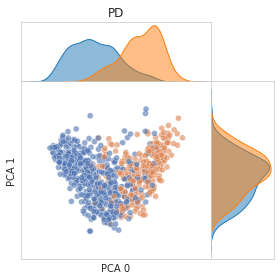

In [16]:
fig = joint_plot(obs_pca_result[:,0], obs_pca_result[:,1], obs_PD, 'PD')

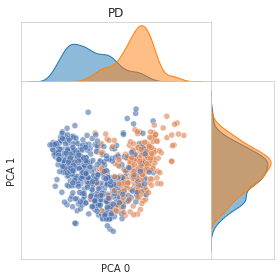

In [17]:
fig = joint_plot(cf_pca_result[:,0], cf_pca_result[:,1], obs_PD, 'PD')

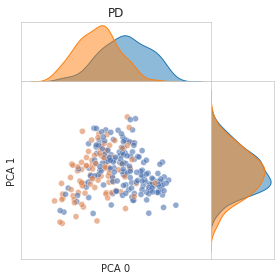

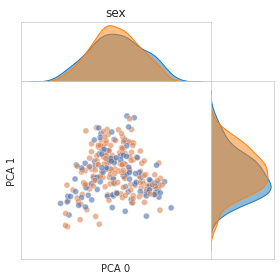

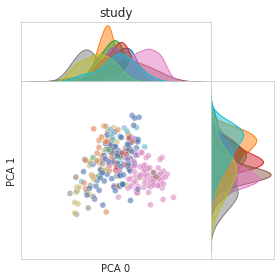

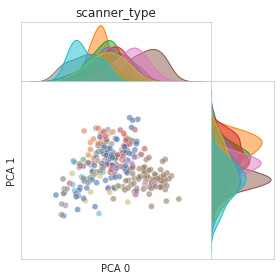

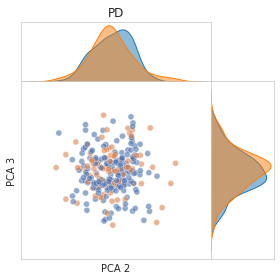

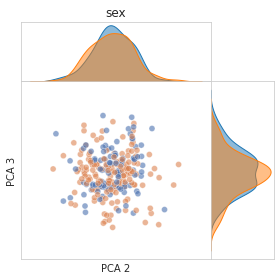

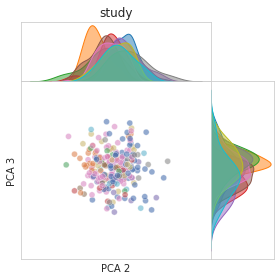

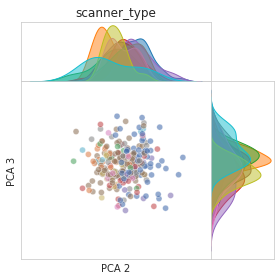

In [32]:
cols = [obs_PD, obs_sex, obs_study, obs_scanner_type]
names = ['PD', 'sex', 'study', 'scanner_type']
comps_tuple = ([0,1], [2,3])

for comps in comps_tuple:
    for c, n in zip(cols, names):
        joint_plot(comps, c, n)
        # joint_plot(comps, c, n).savefig(f'/data/Papers/MICCAI-biases/pca/{mode}_{test_block}_pca_{comps[0]}_{comps[1]}_{n}.pdf')